In [1]:
import sys
sys.path.append('../')
from model.Unet import *
from utils.generate_data import *
from keras.callbacks import *
from keras.models import *
from keras.layers import *
from keras.optimizers import *

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]='2'

Using TensorFlow backend.
/home/possibleit/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/possibleit/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/possibleit/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/possibleit/

In [2]:
model = unet(512, 512, 3, 12)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 256, 256, 64) 0           conv2d_2[0][0]                   
____________________

In [3]:
model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=["accuracy"])

In [9]:
log_dir='log/unet'
tb_cb = TensorBoard(log_dir=log_dir)
model_checkpoint = keras.callbacks.ModelCheckpoint(log_dir + '/CamVid_model.hdf5', monitor='val_loss',verbose=1,save_best_only=True)
rl = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=3,
    verbose=1
)
es = EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    patience=10, 
    verbose=1
)
csv_logger = CSVLogger(log_dir + '/training.log')

In [10]:
train_data = trainGenerator(batch_size=1)
valid_data = validLoad(batch_size=1)
test_data = testGenerator()

In [12]:
history = model.fit_generator(train_data,
                              steps_per_epoch=200,
                              epochs=60,
                              validation_steps=10,
                              validation_data=valid_data,
                              callbacks=[model_checkpoint,tb_cb, rl, es, csv_logger])

Epoch 1/60
200/200 [==============================] - 171s 854ms/step - loss: 0.9701 - accuracy: 0.6565 - val_loss: 1.2253 - val_accuracy: 0.6217

Epoch 00001: val_loss improved from inf to 1.22531, saving model to log/unet/CamVid_model.hdf5
Epoch 2/60
200/200 [==============================] - 172s 861ms/step - loss: 0.8632 - accuracy: 0.6816 - val_loss: 1.0854 - val_accuracy: 0.6963

Epoch 00002: val_loss improved from 1.22531 to 1.08535, saving model to log/unet/CamVid_model.hdf5
Epoch 3/60
200/200 [==============================] - 179s 896ms/step - loss: 0.7911 - accuracy: 0.7080 - val_loss: 0.9874 - val_accuracy: 0.6576

Epoch 00003: val_loss improved from 1.08535 to 0.98739, saving model to log/unet/CamVid_model.hdf5
Epoch 4/60
200/200 [==============================] - 176s 878ms/step - loss: 0.8005 - accuracy: 0.7021 - val_loss: 0.8664 - val_accuracy: 0.7118

Epoch 00004: val_loss improved from 0.98739 to 0.86644, saving model to log/unet/CamVid_model.hdf5
Epoch 5/60
200/200 [

In [13]:
model.save_weights(log_dir+'/unet_weight.h5')

In [26]:
(x, y) = trainGenerator(batch_size=1).__next__()
img = model.predict(x)
img = np.squeeze(img)
img.shape
m = test_data.__next__()
m.shape

Found 367 images belonging to 1 classes.
Found 367 images belonging to 1 classes.


(1, 512, 512, 3)

In [27]:
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import numpy as np

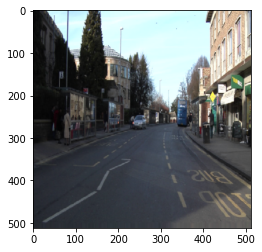

(512, 512, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


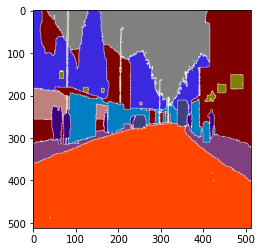

In [28]:
x = np.squeeze(x)
y = np.squeeze(y)
plt.imshow(x)
plt.show()
res = np.empty([512,512,3], dtype = int)
print(res.shape)
for i in range(512):
    for j in range(512):
        for k in range(12):
            if y[i][j][k] == 1:
                res[i][j] = COLOR_DICT[k]
                break
plt.imshow(res)
plt.show()

(512, 512, 3)


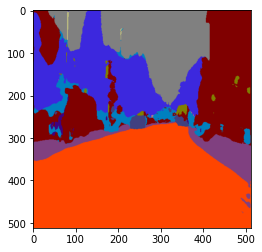

In [29]:
img2 = np.empty([512,512,3], dtype = int)
print(img2.shape)
for i in range(512):
    for j in range(512):
        img2[i][j] = COLOR_DICT[np.argmax(img[i][j])]
plt.imshow(img2)
plt.show()

(512, 512, 3)


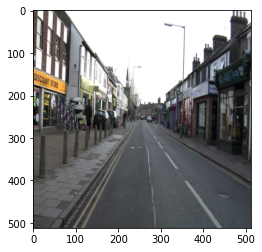

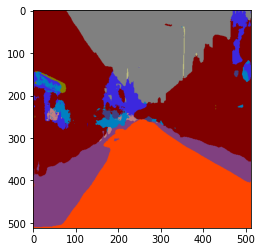

In [30]:
img = model.predict(m)
img = np.squeeze(img)
img2 = np.empty([512,512,3], dtype = int)
print(img2.shape)
for i in range(512):
    for j in range(512):
        img2[i][j] = COLOR_DICT[np.argmax(img[i][j])]
m = np.squeeze(m)
plt.imshow(m)
plt.show()
plt.imshow(img2)
plt.show()